Final Project

Bryan Werth

In [8]:
class Football(Suite):

    def __init__(self, mu, sigma, num_sigmas, label=None):
        pmf = MakeNormalPmf(mu, sigma, num_sigmas, n=101)
        Suite.__init__(self, pmf, label=label)
            
    def Likelihood(self, data, hypo):
        """
        hypo: point scoring rate in points per game per scoring method
        data: points scored in one game one way
        """
        lam = hypo
        k = data
        return EvalPoissonPmf(k, lam)

First, I defined a general football class to handle each teams scoring rates for touchdowns and field goals. In creating this class, I extend the previously defined Suite class because what I want to do in creating a Pmf for this problem is very similar, but with a different Likelihood and init method. For the initialization method, I created a normal pmf prior and used this to extend the Suite init method. I used a normal prior here because the number of points seemed well modeled by a prior with the maximum at the average and lower probabilities on either side. A normal prior continues in either direction forever, which does not make sense in this case. However, given the input data, the model should work. To create a normal pmf prior using the MakeNormalPmf method from the thinkbayes2 module, there needs to be a user inputted mu (average number of points per game), sigma (standard deviation), and number of sigmas (number of standard deviations. For this problem, the number of points per game per scoring method is the hypothesis and the data is the points scored one way in one game. This means I need to find the probability of a specific number of points given the scoring rate in the likelihood method. In this method, I first unpack the hypothesis and data inputs before using the inputted values to find the probability of a specific number of points given a scoring rate. For this, I use the EvalPoissonPmf method from the thinkbayes2 module because a poisson pmf is best used to model the time between events, such as a scoring rate. 

It is also useful to have a function that will create a mixture from a metapmf based on the distribution of scoring rates inputted as a suite. To do this, we first define a metapmf that we will add to as we run through a for loop. Following this, we run through the list of scoring rate and probability of said scoring rate combinations. We make a poissonpmf for the given lambda value for the above reasons. We finally add the newly defined pmf to the metapmf with the lambda values probability using the pmf Set method from the thinkbayes2 module. Based on the newly defined metapmf, we make a mixture of the lambda distributions using the MakeMixture method, also from the thinkbayes2 module. 

In [9]:
def MakeGoalPmf(suite, high = 10):
    metapmf = Pmf()
    for lam, prob in suite.Items():
        pmf = MakePoissonPmf(lam, high)
        metapmf.Set(pmf, prob)
    return MakeMixture(metapmf, label=suite.label)

In order to answer the posed question, it is important to have data of the past performances of every nfl team. In collecting data, I focused on the past four seasons because the patriots have played every nfl team in that time-span. With this data, I calculated the average number of touchdowns per game and average number of field goals per game along with relevant standard deviations. With this information found (calculated in a spreadsheet available at the bottom), I put it all in two dictionaries (one for touchdowns and one for field goals) for easy access.

In [10]:
NFLTDsDict = {'Patriots':(3.125,.781),'Saints':(3.125,.781),'Packers':(2.85,.71),'Broncos':(3.225,.806),'Redskins':(2.375,.5935),'Giants':(2.475,.5935),'Falcons':(2.4,.575),'Seahawks':(2.65,.66),'Texans':(2.15,.535),'Panthers':(2.6,.6),'49ers':(2.05,.51),'Buccaneers':(2.05,.51),'Ravens':(2.125,.531),'Lions':(2.45,.61),'Bengals':(2.7,.65),'Cowboys':(2.475,.6185),'Bills':(2.175,.5435),'Steelers':(2.45,.61),'Vikings':(2.125,.531),'Colts':(2.425,.606),'Bears':(2.325,.581),'Chargers':(2.225,.556),'Eagles':(2.525,.631),'Dolphins':(2.1,.5),'Browns':(1.775,.4435),'Raiders':(2.025,.506),'Titans':(1.975,.4935),'Rams':(1.825,.456),'Jets':(1.925,.481),'Jaguars':(1.75,.435),'Cardinals':(2.125,.531),'Chiefs':(2.1,.5)}
NFLFGsDict = {'Patriots':(2.025,.506),'Saints':(1.25,.31),'Packers':(1.725,.431),'Broncos':(1.7,.4),'Redskins':(1.45,.36),'Giants':(1.725,.431),'Falcons':(1.75,.435),'Seahawks':(1.8,.4475),'Texans':(1.75,.435),'Panthers':(1.525,.381),'49ers':(1.725,.431),'Buccaneers':(1.55,.385),'Ravens':(2,.475),'Lions':(1.55,.385),'Bengals':(1.5,.35),'Cowboys':(1.725,.431),'Bills':(1.725,.431),'Steelers':(1.95,.485),'Vikings':(1.875,.4685),'Colts':(1.8,.4475),'Bears':(1.55,.385),'Chargers':(1.675,.4185),'Eagles':(1.6,.375),'Dolphins':(1.4,.3475),'Browns':(1.625,.406),'Raiders':(1.425,.356),'Titans':(1.325,.331),'Rams':(1.45,.36),'Jets':(1.775,.4435),'Jaguars':(1.45,.36),'Cardinals':(1.725,.431),'Chiefs':(1.7,.4)}

With all of the above infrastructure established, we can predict the winner of each of the games in Patriots 2016 schedule. 

   First, we will look at the Patriots week one opponents. We start by using the above dictionaries to define the average number of field goals and touchdowns along with the respective standard deviations for both teams. With this data, we can define a four Football Pmf list with touchdown suites and field goal suites for each team. We also define a list of nested lists of the number of touchdowns and field goals for each team against the other in the last four years (in the form [patriotsTDs,patriotsFGs,opponentTDs,opponentFGs). We also initialize an empty list that we will fill with goal distribution mixtures later on. We can use a for loop to update the defined pmfs and make final goal distribution mixtures using the previously defined MakeGoalPmf function. Once both of these things are done for the four pmfs, we calculate the probable score for each team by taking the mean of the TD and FG pmfs for each team and multiplying them by the right number of points for each way of scoring.
    
   It is important to note here that the score for each team is not based on the historical number of wins and losses of the two teams. The score is based only on the number of touchdowns and field goals scored by each team on average and the number of touchdowns and field goals allowed by one team when playing the other. Reasonably, there should be some correlation between historical number of wins against each other for this reason, but they are not directly related. 

In [89]:
def GamePrediction(Opponents,Updates):
    OpponentsTDAverage, OpponentsTDSTD = NFLTDsDict[Opponents]
    OpponentsFGAverage, OpponentsFGSTD = NFLFGsDict[Opponents]
    PatriotsVsOpponents = [Football(PatriotsTDAverage,PatriotsTDSTD,4),Football(PatriotsFGAverage,PatriotsFGSTD,4),Football(OpponentsTDAverage,OpponentsTDSTD,4),Football(OpponentsFGAverage,OpponentsFGSTD,4)]
    PatriotsVsOpponentsUpdates = Updates
    PatriotsVsOpponentsGD = []
    for i in range(4):
        PatriotsVsOpponents[i].UpdateSet(PatriotsVsOpponentsUpdates[i])
        PatriotsVsOpponentsGD.append(MakeGoalPmf(PatriotsVsOpponents[i]))
    PatriotsVsOpponentsDistribution = PatriotsVsOpponentsGD[0].Scale(7)+PatriotsVsOpponentsGD[1].Scale(3)
    OpponentsVsPatriotsDistribution = PatriotsVsOpponentsGD[2].Scale(7)+PatriotsVsOpponentsGD[3].Scale(3)
    return PatriotsVsOpponentsDistribution,OpponentsVsPatriotsDistribution

In [91]:
PatriotsVsCardinalsDistribution, CardinalsVsPatriotsDistribution = GamePrediction('Cardinals',[[1],[4],[2],[2]])

19.2689526653
14.8753757562


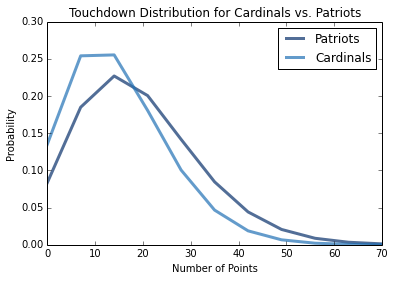

In [92]:
thinkplot.Pdf(PatriotsVsCardinalsGD[0].Scale(7))
thinkplot.Pdf(PatriotsVsCardinalsGD[2].Scale(7))
thinkplot.Config(title = 'Touchdown Distribution for Cardinals vs. Patriots',xlabel = 'Number of Points',ylabel = 'Probability')
print(PatriotsVsCardinalsGD[0].Scale(7).Mean())
print(PatriotsVsCardinalsGD[2].Scale(7).Mean())

When we are looking at the distributions of just the touchdowns of the two teams, it is generally clear where the differences are. The Cardinals have the highest probability of scoring around or slightly less than two touchdowns. The Patriots have a similar point distribution, but the highest probability of scoring is slightly higher and the probability of larger numbers of points is consistently higher. For these reasons, the Patriots are probably going to score more points. The mean of both distributions reaffirms this: the Patriots will most likely score 19 points from touchdowns and the Cardinals will most likely score 15 points. It is worth noting that it is not possible to score 19 points or 15 points from touchdowns alone, but the distributions are describing the probable number of touchdowns. The mean of the pmf or the most probable value will not always be an integer, so the predictions may not always make total sense within the context of an actual game.

It can also be useful to plot the histograms for the above touchdown distributions. As can be seen below, the Cardinals distribution favors smaller point totals when compared to the Patriots distribution.

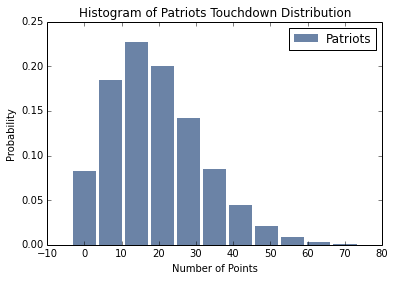

In [62]:
thinkplot.Hist(PatriotsVsCardinalsGD[0].Scale(7))
thinkplot.Config(title = 'Histogram of Patriots Touchdown Distribution',xlabel = 'Number of Points',ylabel = 'Probability')

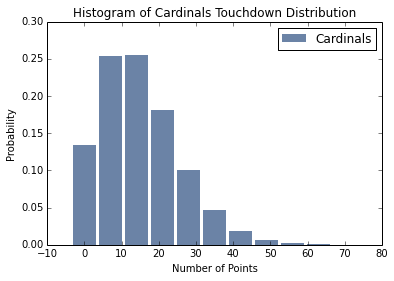

In [63]:
thinkplot.Hist(PatriotsVsCardinalsGD[2].Scale(7))
thinkplot.Config(title = 'Histogram of Cardinals Touchdown Distribution',xlabel = 'Number of Points',ylabel = 'Probability')

6.73818549306
5.2890795263


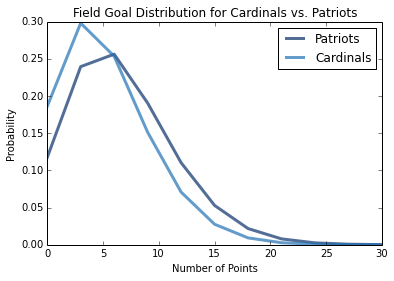

In [74]:
thinkplot.Pdf(PatriotsVsCardinalsGD[1].Scale(3))
thinkplot.Pdf(PatriotsVsCardinalsGD[3].Scale(3))
thinkplot.Config(title = 'Field Goal Distribution for Cardinals vs. Patriots',xlabel = 'Number of Points',ylabel = 'Probability')
print(PatriotsVsCardinals[1].Scale(3).Mean())
print(PatriotsVsCardinals[3].Scale(3).Mean())

As can be seen by looking at the above field goal distribution graph, the Patriots are also more likely to score more field goals. Just before five points from field goals, there is a sharp jump in the probability of the  Cardinals distribution. Following this, the probability declines quickly. The Patriots maintain a reasonably high probability for higher point totals, so it makes sense that they will probably score more field goals than the Cardinals. The mean of both distributions shows that the Patriots will outscore the Cardinals seven to five. 

With a basic understanding of the field goal and touchdown distributions, we can combine the pmfs to get the total score distribution. Based on what we've already seen, we would expect to see the distribution favor the Patriots, and we do. However, it is hard to see this because of how much jumping around there is. Interestingly, this is because there are some scores that are a lot more unlikely than other similar scores. For example, if a team is going to score 25 points, they would need to score one touchdown and six field goals which is a lot more unlikely than scoring three touchdowns (21 points). It is also worth mentioning that both teams have a non-zero chance of scoring one to two points. This doesn't strictly make sense, except for the fact that the point distributions are found by scaling distributions for the number of touchdowns or field goals. With these early distributions, any number of field goals or touchdowns is reasonable and when we scale, we just stretch the pmf.

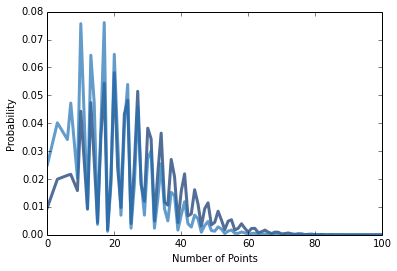

In [68]:
thinkplot.Pdf(PatriotsVsCardinalsDistribution)
thinkplot.Pdf(CardinalsVsPatriotsDistribution)
thinkplot.Config(xlabel = 'Number of Points',ylabel = 'Probability')

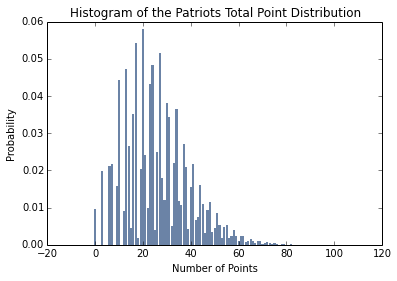

In [70]:
thinkplot.Hist(PatriotsVsCardinalsDistribution)
thinkplot.Config(title = 'Histogram of the Patriots Total Point Distribution',xlabel='Number of Points',ylabel='Probability')

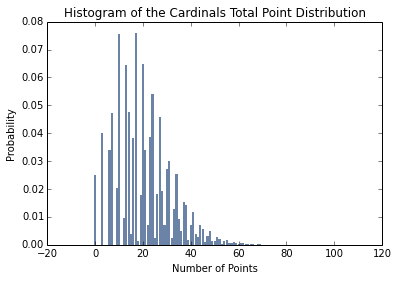

In [71]:
thinkplot.Hist(CardinalsVsPatriotsDistribution)
thinkplot.Config(title = 'Histogram of the Cardinals Total Point Distribution',xlabel='Number of Points',ylabel='Probability')

It is easier to see the differences between the total distributions of both teams when looking at the histograms. As with the individual touchdown and field goal distributions, there is more spread to the Patriots distribution. This means there is more of a chance of them scoring more points. The Cardinals have a very high chance of having a lower score. 

In [72]:
print(PatriotsVsCardinalsDistribution.Mean())
print(CardinalsVsPatriotsDistribution.Mean())

26.005339778
20.1641630066


According to the model of the first game, the Patriots will win at a score of 26 to 20. As we know, in the actual game the Patriots won with a score of 23 to 21. This is fairly close, but more importantly, this early data supports the validity of the model.

From here, I will run through models for the next seven games on the schedule, which have already happened, in short-form.

In [93]:
#Week 2: Dolphins vs. Patriots
PatriotsVsDolphinsDistribution, DolphinsVsPatriotsDistribution = GamePrediction('Dolphins',[[2,4,3,2,2,5,4,1],[3,0,2,2,2,2,2,1],[1,0,2,3,3,1,1,2],[3,0,1,1,4,2,0,2]])
print(PatriotsVsDolphinsDistribution.Mean())
print(DolphinsVsPatriotsDistribution.Mean())

26.8431382742
17.7372741762


For this game, the Patriots are predicted to win 27 to 18. In the actual game, the Patriots won 31 to 24.

In [94]:
#Week 3: Texans vs. Patriots
PatriotsVsTexansDistribution, TexansVsPatriotsDistribution = GamePrediction('Texans',[[6,4,3],[0,2,1],[2,4,0],[0,1,2]])
print(PatriotsVsTexansDistribution.Mean())
print(TexansVsPatriotsDistribution.Mean())

30.1419298454
19.6546106997


For this game, the Patriots are predicted to win 30 to 20. In the actual game, the Patriots won 27 to 0.

In [95]:
#Week 4: Bills vs. Patriots
PatriotsVsBillsDistribution, BillsVsPatriotsDistribution = GamePrediction('Bills',[[7,4,2,3,4,0,4,2],[4,4,3,2,3,2,5,1],[1,3,3,4,3,3,4,2],[0,1,0,2,0,1,0,2]])
print(PatriotsVsBillsDistribution.Mean())
print(BillsVsPatriotsDistribution.Mean())

30.1472914438
21.4629512316


For this game, the Patriots are predicted to win 30 to 21. In the actual game, the Bills won 16 to 0.

In [96]:
#Week 5: Browns vs. Patriots
PatriotsVsBrownsDistribution, BrownsVsPatriotsDistribution = GamePrediction('Browns',[[3],[2],[3],[2]])
print(PatriotsVsBrownsDistribution.Mean())
print(BrownsVsPatriotsDistribution.Mean())

27.983273104
18.3384058488


In this game, the Patriots are predicted to win 28 to 18. In the actual game, the Patriots won 33 to 13.

In [97]:
#Week 6: Bengals vs. Patriots
PatriotsVsBengalsDistribution, BengalsVsPatriotsDistribution = GamePrediction('Bengals',[[0,4],[2,5],[1,2],[2,1]])
print(PatriotsVsBengalsDistribution.Mean())
print(BengalsVsPatriotsDistribution.Mean())

26.693158299
21.4319966514


The Patriots are predicted to beat the Bengals 27 to 21. In the actual game, the Patriots won 35 to 17.

In [98]:
#Week 7: Steelers vs. Patriots
PatriotsVsSteelersDistribution, SteelersVsPatriotsDistribution = GamePrediction('Steelers',[[7,4],[2,0],[4,2],[1,2]])
print(PatriotsVsSteelersDistribution.Mean())
print(SteelersVsPatriotsDistribution.Mean())

31.5438745579
23.8381927557


The Patriots are predicted to win this game against the Steelers 32 to 24. In the actual game, the Patriots won 27 to 16.

In [99]:
#Week 8: Bills vs. Patriots
PatriotsVsBillsDistribution, BillsVsPatriotsDistribution = GamePrediction('Bills',[[7,4,2,3,4,0,4,2,3],[4,4,3,2,3,2,5,1,3],[1,3,3,4,3,3,4,2,3],[0,1,0,2,0,1,0,2,0]])
print(PatriotsVsBillsDistribution.Mean())
print(BillsVsPatriotsDistribution.Mean())

30.1212713976
21.3538298101


The Patriots are predicted to win this game 30 to 21. In the actual game, the Patriots won 41 to 25.

Overall, the Patriots were predicted to win all of the first eight games of the season. In this span, the Patriots actually won seven of the eight games. The Patriots had some of the highest average number of touchdowns per game and field goals per game in the NFL over the course of the past four seasons. Considering the relatively small amount of specific data available for specific team combinations, these overall scoring rates will have the largest effect on game outcome predictions. Due to this, the Patriots will reasonably be predicted to win most (if not all) games. However, this speaks to the consistency of the Patriots, which is an integral part of a football team's long term success. For all these reasons, there will be the occasional wrong prediction, but the model is accurate for most games and will be useful for predicting future games.

In [100]:
#Week 10: Seahawks vs. Patriots
PatriotsVsSeahawksDistribution, SeahawksVsPatriotsDistribution = GamePrediction('Seahawks',[[4,4],[2,0],[5,3],[2,1]])
print(PatriotsVsSeahawksDistribution.Mean())
print(SeahawksVsPatriotsDistribution.Mean())

29.1493731646
26.1689405219


The Patriots are predicted to win this game 29 to 26.

In [101]:
#Week 11: 49ers vs. Patriots
PatriotsVsFNersDistribution, FNersVsPatriotsDistribution = GamePrediction('49ers',[[2],[3],[3],[1]])
print(PatriotsVsFNersDistribution.Mean())
print(FNersVsPatriotsDistribution.Mean())

27.0930447392
20.1580247199


The Patriots are predicted to win this game against the 49ers 27 to 20.

In [102]:
#Week 12: Jets vs. Patriots
PatriotsVsJetsDistribution, JetsVsPatriotsDistribution = GamePrediction('Jets',[[3,7,1,3,3,2,3,2],[2,0,2,2,2,1,3,2],[2,2,1,3,2,1,2,3],[4,1,1,3,4,3,3,2]])
print(PatriotsVsJetsDistribution.Mean())
print(JetsVsPatriotsDistribution.Mean())

27.3787451456
20.4118960388


The Patriots are predicted to win this game against the Jets 27 to 20.

In [103]:
#Week 13: Rams vs. Patriots
PatriotsVsRamsDistribution, RamsVsPatriotsDistribution = GamePrediction('Rams',[[6],[1],[1],[0]])
print(PatriotsVsRamsDistribution.Mean())
print(RamsVsPatriotsDistribution.Mean())

30.6646179338
16.1801412836


The Patriots are predicted to win this game against the Rams 31 to 16.

In [104]:
#Week 14: Ravens vs. Patriots
PatriotsVsRavensDistribution, RavensVsPatriotsDistribution = GamePrediction('Ravens',[[3,1,5,5],[3,2,2,0],[4,4,1,4],[1,0,0,1]])
print(PatriotsVsRavensDistribution.Mean())
print(RavensVsPatriotsDistribution.Mean())

29.1278307667
21.8542305547


The Patriots are predicted to win this game against the Ravens 27 to 18.

In [105]:
#Week 15: Broncos vs. Patriots
PatriotsVsBroncosDistribution, BroncosVsPatriotsDistribution = GamePrediction('Broncos',[[4,4,2,4,3,2],[1,2,1,5,1,2],[3,4,2,3,3,2],[0,1,4,0,3,2]])
print(PatriotsVsBroncosDistribution.Mean())
print(BroncosVsPatriotsDistribution.Mean())

28.4572534918
26.4947792856


The Patriots are predicted to win this game against the Broncos 28 to 26.

In [106]:
#Week 16: Jets vs. Patriots
PatriotsVsJetsDistribution, JetsVsPatriotsDistribution = GamePrediction('Jets',[[3,7,1,3,3,2,3,2,3],[2,0,2,2,2,1,3,2,2],[2,2,1,3,2,1,2,3,3],[4,1,1,3,4,3,3,2,0]])
print(PatriotsVsJetsDistribution.Mean())
print(JetsVsPatriotsDistribution.Mean())

27.3674125187
20.5126778766


The Patriots are predicted to win this game against the Jets 27 to 21.

In [107]:
#Week 17: Dolphins vs. Patriots
PatriotsVsDolphinsDistribution, DolphinsVsPatriotsDistribution = GamePrediction('Dolphins',[[2,4,3,2,2,5,4,1,4],[3,0,2,2,2,2,2,1,1],[1,0,2,3,3,1,1,2,3],[3,0,1,1,4,2,0,2,1]])
print(PatriotsVsDolphinsDistribution.Mean())
print(DolphinsVsPatriotsDistribution.Mean())

27.1787133602
18.1721369696


The Patriots are predicted to beat the Dolphins in week 17 27 to 18.

As with the first eight games, the Patriots are predicted to win the final eight games of the season. However, considering how close the scoreline is in the Broncos and Seahawks games, the Patriots could reasonably win anywhere between six and eight games. Also, there are other situational factors that aren't being considered in this model. The Patriots only have a two point lead against the Seahawks and Broncos, so these games are probably too close to call. 

In total, the Patriots are predicted to win somewhere between 13 and 15 games this season under this model.

Conclusions and Future Work

I achieved a reasonable amount of success in completing this project. I showed that my model is reasonably accurate, working in seven of eight cases. 

Despite the accuracy of the model, there are several extensions that would be interesting to pursue in the future. First, I would like to factor in failed extra points, two point conversions, and defensive safeties. I could do this using the same Football class with different data, assuming there is good data for the average number of extra points, two point conversions, and safeties per game. This extension would be interesting, but I do not think it would change the results significantly. I would also like to factor in the absence of significant players. For example, for the first four games of the season Tom Brady was suspended. This was considered a major problem for the Patriots, who were expected to win only two of the first four games at best. Knowing this, the unusual scoreline for the first Bills game makes sense. It would be useful to be able to factor in the absence of players like Brady. However, in order to do this, I would need data on how the Patriots play with and without key players. Factoring in this data would require a significant change in modeling strategy. I would also like to weight the more recent games against the opponent differently than older games. This would be interesting, but I'm not totally sure how I would do this yet. 